# Methodology

## Note

The model's out-of-sample performance on datasets from different time periods is moderate due to the effects of COVID-19 on the 2020 dataset. While the ROC AUC for the 2015 test set is 83%, it decreases to 74% for the 2020 validation set—a drop of about 10%. If different time periods are used for the validation set, the out-of-sample ROC AUC improves to around 78%. However, these results are not included in this report.

## Data Sources

### 1. Freddie Mac Single Family Loan-Level Dataset

- **Usage**:
  - 2015 dataset for training and testing
  - 2020 dataset for validation
- **Source**: [Freddie Mac Single Family Loan-Level Dataset](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset)

### 2. Freddie Mac Mortgage Rates

- **Usage**: Monthly mean mortgage rates for 15-year and 30-year fixed mortgages
- **Source**: [Freddie Mac Primary Mortgage Market Survey (PMMS)](https://www.freddiemac.com/pmms)

### 3. House Price Index (HPI)

- **Source**: [Federal Housing Finance Agency (FHFA) HPI Datasets](https://www.fhfa.gov/data/hpi/datasets)

### 4. Unemployment Rate (State & National Levels)

- **Source**: [U.S. Bureau of Labor Statistics (BLS) State Unemployment Rates](https://www.bls.gov/charts/state-employment-and-unemployment/state-unemployment-rates-animated.htm)

### 5. Consumer Price Index (CPI) (Removed)

- **Note**: The CPI data was considered but ultimately removed from the analysis.
- **Source**: [U.S. Bureau of Labor Statistics (BLS) CPI Data](https://www.bls.gov/charts/state-employment-and-unemployment/state-unemployment-rates-animated.htm)

## Files

- **`mortgage_feature_analysis.ipynb`**: Contains the data analysis and feature engineering processes.
- **`model.py`**: Includes model definitions, hyperparameter tuning, and training functions.
- **`helper_functions.py`**: Contains utility functions for data cleaning, processing, and visualization.

## Feature Engineering

- **Monthly Mean Rates**: Obtained from Freddie Mac Mortgage Rates for 15-year and 30-year fixed mortgages.

- **`Interest Rate Difference (%)`**:
  $$
  \text{Interest Rate Diff (\%)} = \frac{\text{Original Interest Rate} - \text{Monthly Mean}}{\text{Monthly Mean}} \times 100
  $$

- **`Spread at Origination (SATO)`**:
  $$
  \text{SATO} = \text{Original Interest Rate} - \text{U.S. 30-Year FRM (Monthly Mean)}
  $$

- **`Z-score at Origination (ZATO)`**:
  - Since Freddie Mac does not provide the standard deviation for each month, it was calculated using the 2015 and 2020 datasets:
    $$
    \text{ZATO} = \frac{\text{Original Interest Rate} - \text{Mean Original Interest Rate}}{\text{Standard Deviation of Original Interest Rate}}
    $$

- **`index_sa_state_mom12`**: Represents the 12-month momentum for state-level data.

### Final Feature Set Used

- **Categorical Features**:
  - `first_time_homebuyer_flag`
  - `occupancy_status`
  - `loan_purpose`
  - `property_state`

- **Numerical Features**:
  - `borrowers_times_credit_score`
  - `sato_f30`
  - `zato`
  - `credit_score`
  - `original_debt_to_income_ratio`
  - `original_upb`
  - `original_loan_term`
  - `original_loan_to_value`
  - `interest_diff_percentage`
  - `number_of_borrowers`
  - `index_sa_state_mom12`
  - `State Unemployment Rate`
  - `credit_score_times_debt_to_income_ratio`
  - `credit_score_times_loan_to_value`

## Model

### Algorithms Used

- **Logistic Regression**
- **Random Forest**
- **XGBoost**

### Data Splitting

- **2015 Dataset**:
  - Split into training (75%) and testing (15%) sets.
- **2020 Dataset**:
  - Used as the validation set.

### Evaluation Metric

- **ROC AUC**: Used to evaluate model performance.

### Training and Tuning Process

1. **Training**: Models were trained using the training set.
2. **Hyperparameter Tuning**:
   - Performed using [Optuna](https://optuna.org/), a Bayesian hyperparameter tuning framework.
   - The test set was used to tune the models.
3. **Validation**: The validation set was used for final performance evaluation.

## Feature Importance

Two methods were employed to assess feature importance:

1. **Permutation Importance**:
   - Randomly permuate a feature and evaluate the change in model performance: [Permutation Importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
2. **Tree-Based Impurity Importance**:
   - Applied to tree-based models like Random Forest and XGBoost when available.


## **Results**

**Based on both permutation importance and tree-based importance methods, the feature importance scores are as follows:**

- **SATO has a slightly higher importance than ZATO.**
- **Both SATO and ZATO are significantly more important than Interest Difference in Percentage (IDP).**





# Loading

**`Click on CODE button on the right and you will see the underlying code`**

**`You can also switch between tabsets, eg. Histogram, Binning section`**

In [1]:
%load_ext pretty_jupyter
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import psycopg2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import helper.helper_functions as hp
import model as m


# jupyter nbconvert --to html --template pj mortage_feature_analysis.ipynb

In [2]:
# Marco
df_hpi = pd.read_csv('Data/hpi_po_state.csv', parse_dates=['date'])
df_hpi['index_sa_state_mom12'] = df_hpi.groupby('state')['index_sa'].pct_change(12)

df_cpi = pd.read_csv('Data/CPIAUCSL.csv',  parse_dates=['DATE'])

df_unemp_state = pd.read_csv('Data/unemp_rate.csv')
df_unemp_state = pd.melt(df_unemp_state, id_vars=['State'], var_name='Date', value_name='Unemployment Rate')
df_unemp_state['Date'] = pd.to_datetime(df_unemp_state['Date'], format='%b-%y')
df_unemp_state['State Abbreviation'] = df_unemp_state['State'].map(hp.state_abbreviations)

df_unemp_national = pd.read_csv('Data/UNRATE.csv', parse_dates=['DATE'])

# Freddie Mac weekly mortgage rates 
df_interest_rate = pd.read_excel('Data/Freddie_interest_rate.xlsx', parse_dates=['Week'])


In [3]:
# Performance
with psycopg2.connect(database="postgres", host="localhost", user="postgres", password="542623", port="5432") as conn:
    sql_svcg_2015 = "SELECT * FROM sample_svcg_2015;"
    df_svcg_2015 = pd.read_sql(sql_svcg_2015, conn, parse_dates=['monthly_reporting_period'])

    sql_svcg_2020 = "SELECT * FROM sample_svcg_2020;"
    df_svcg_2020 = pd.read_sql(sql_svcg_2020, conn, parse_dates=['monthly_reporting_period'])

C:\Users\Howard\AppData\Local\Temp\ipykernel_23384\3008230335.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_svcg_2015 = pd.read_sql(sql_svcg_2015, conn, parse_dates=['monthly_reporting_period'])
C:\Users\Howard\AppData\Local\Temp\ipykernel_23384\3008230335.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_svcg_2020 = pd.read_sql(sql_svcg_2020, conn, parse_dates=['monthly_reporting_period'])


In [4]:
# Origination
with psycopg2.connect(database="postgres", host="localhost", user="postgres", password="542623", port="5432") as conn:
    sql_orig_2015 = "SELECT * FROM sample_orig_2015;"
    df_orig_2015 = pd.read_sql(sql_orig_2015, conn, parse_dates=['first_payment_date'])

    sql_orig_2020 = "SELECT * FROM sample_orig_2020;"
    df_orig_2020 = pd.read_sql(sql_orig_2020, conn, parse_dates=['first_payment_date'])

C:\Users\Howard\AppData\Local\Temp\ipykernel_23384\1488673024.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orig_2015 = pd.read_sql(sql_orig_2015, conn, parse_dates=['first_payment_date'])
C:\Users\Howard\AppData\Local\Temp\ipykernel_23384\1488673024.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orig_2020 = pd.read_sql(sql_orig_2020, conn, parse_dates=['first_payment_date'])


# Feature Enginnering
[//]: <> (-.- tabset)

## Calculating D60, SATO, ZATO, IDP

In [5]:
df_orig_2015['30yrFRM'] = np.where(df_orig_2015['original_loan_term'] / 12 >= 25, True, False)
df_orig_2020['30yrFRM'] = np.where(df_orig_2020['original_loan_term'] / 12 >= 25, True, False)

df_interest_rate['Month'] = df_interest_rate['Week'].dt.month
df_interest_rate['Year'] = df_interest_rate['Week'].dt.year

monthly_avg_rate = df_interest_rate.groupby(['Year', 'Month']).mean().reset_index()

monthly_avg_rate['Date'] = monthly_avg_rate['Year'].astype(str) + '-' + monthly_avg_rate['Month'].astype(str) + '-' + '01'
monthly_avg_rate['Date'] = pd.to_datetime(monthly_avg_rate['Date'])

monthly_avg_rate.drop(['Year', 'Month', 'Week'], axis=1, inplace=True)

df_orig_2015 = hp.process_yearly_data(df_orig_2015, monthly_avg_rate)
df_orig_2020 = hp.process_yearly_data(df_orig_2020, monthly_avg_rate)

df_orig_2015 = hp.process_loan_data(df_orig_2015, df_svcg_2015)
df_orig_2020 = hp.process_loan_data(df_orig_2020, df_svcg_2020)

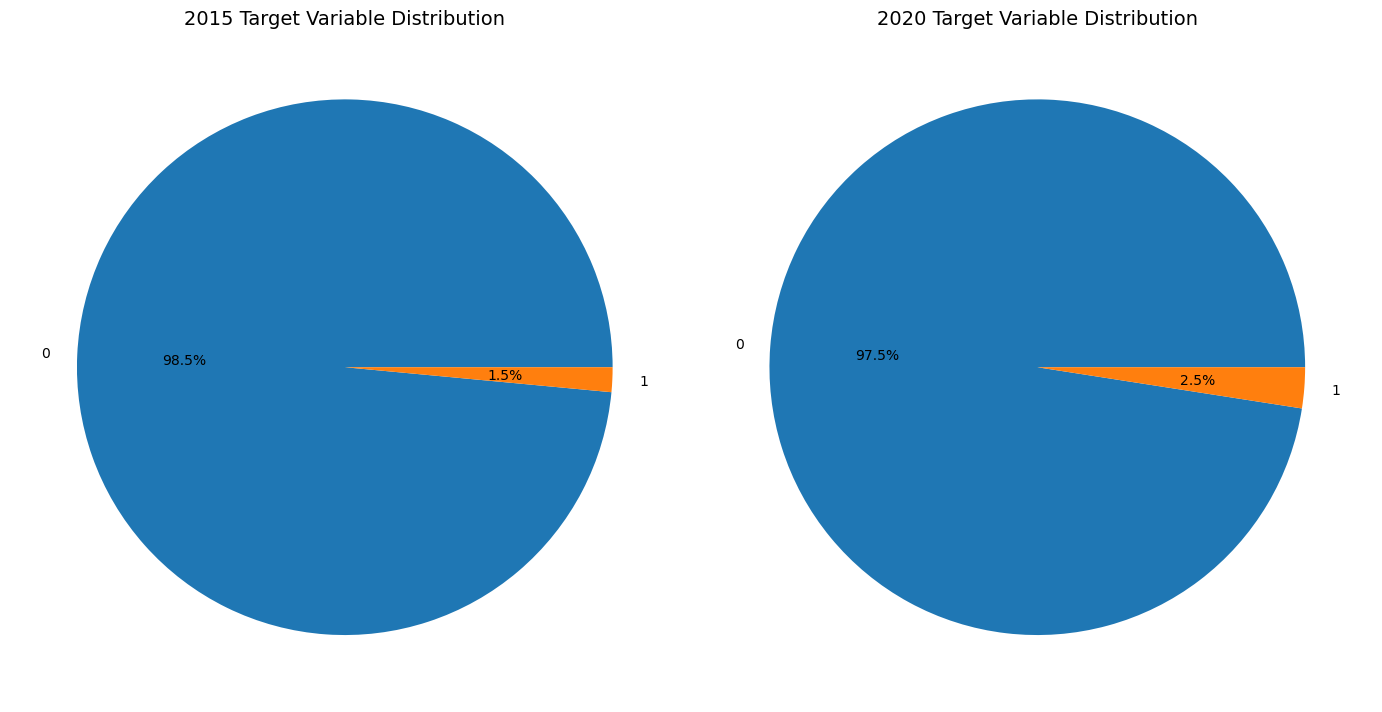

In [6]:
data_2015_counts = df_orig_2015['ever_D60_3years_flag'].value_counts()
data_2020_counts = df_orig_2020['ever_D60_3years_flag'].value_counts()

data_2015_percentages = data_2015_counts / data_2015_counts.sum() * 100
data_2020_percentages = data_2020_counts / data_2020_counts.sum() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(data_2015_percentages, 
            labels=data_2015_percentages.index, 
            autopct='%1.1f%%', 
            )
axes[0].set_title('2015 Target Variable Distribution', fontsize=14)

axes[1].pie(data_2020_percentages, 
            labels=data_2020_percentages.index, 
            autopct='%1.1f%%', 
            )
axes[1].set_title('2020 Target Variable Distribution', fontsize=14)

plt.tight_layout()
plt.show()

## Histogram

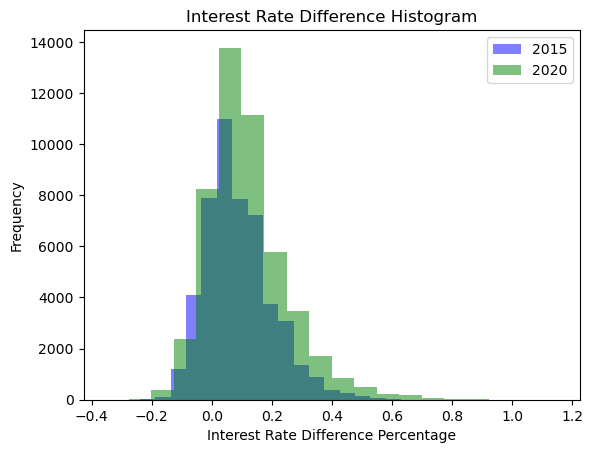

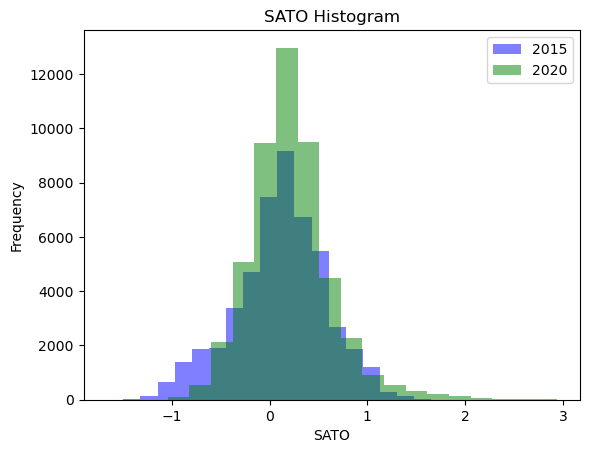

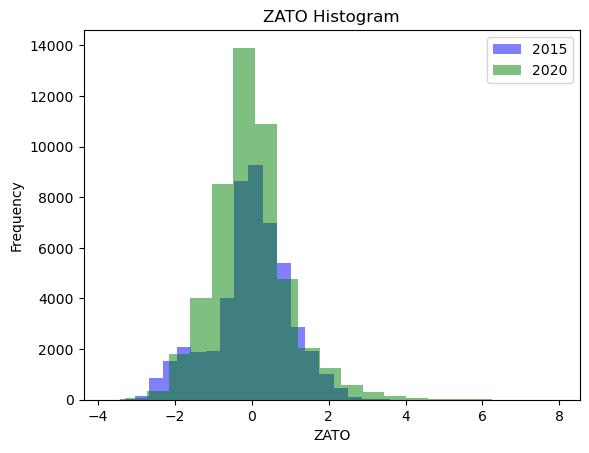

In [7]:
features = [
    {'column': 'interest_diff_percentage', 'title': 'Interest Rate Difference Histogram', 'xlabel': 'Interest Rate Difference Percentage'},
    {'column': 'sato_f30', 'title': 'SATO Histogram', 'xlabel': 'SATO'},
    {'column': 'zato', 'title': 'ZATO Histogram', 'xlabel': 'ZATO'}
]

for feature in features:
    plt.hist(df_orig_2015[feature['column']], bins=20, color='blue', alpha=0.5, label='2015')
    plt.hist(df_orig_2020[feature['column']], bins=20, color='green', alpha=0.5, label='2020')
    plt.title(feature['title'])
    plt.xlabel(feature['xlabel'])
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## Binning

In [8]:
df_orig_2015 = hp.merge_data(df_orig_2015, df_hpi=df_hpi, df_unemp_state=df_unemp_state, df_unemp_national=df_unemp_national, df_cpi=df_cpi)
df_orig_2020 = hp.merge_data(df_orig_2020, df_hpi=df_hpi, df_unemp_state=df_unemp_state, df_unemp_national=df_unemp_national, df_cpi=df_cpi)

df_orig_2015_reg_bins = df_orig_2015.copy()
df_orig_2020_reg_bins = df_orig_2020.copy()


# convert credit score, dti, ltv into categorical bins
# df_orig_2015_reg_bins = hp.bin_columns(df_orig_2015_reg_bins, hp.binning_config)
# df_orig_2020_reg_bins = hp.bin_columns(df_orig_2020_reg_bins, hp.binning_config)

# Model
[//]: <> (-.- tabset)

In [24]:
test_size = 0.25

X = df_orig_2015_reg_bins[hp.categorical_features_ml + hp.numerical_features_ml]
y = df_orig_2015_reg_bins["ever_D60_3years_flag"]


X_val = df_orig_2020_reg_bins[hp.categorical_features_ml + hp.numerical_features_ml]
y_val = df_orig_2020_reg_bins["ever_D60_3years_flag"]

if test_size == 1:
    X_train, X_test, y_train, y_test = X, X, y, y
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=hp.random_state, stratify=y)

X_train_preprocessed, X_test_preprocessed, X_val_preprocessed, feature_names = hp.preprocess_data(X_train, X_test, X_val, hp.numerical_features_ml, hp.categorical_features_ml)

# smote = SMOTE(random_state=42, k_neighbors=5)
# X_train_preprocessed, y_train = smote.fit_resample(X_train_preprocessed, y_train)

## Logistics

In [25]:
logistics = m.ml_model(model_name="logistics")
best_params = logistics.tune(X_train_preprocessed, y_train, X_val_preprocessed, y_val, n_trials=50)

print("=== Logistic Regression ===")
logistics.train(X_train_preprocessed, y_train)

print(f"ROC AUC train: {roc_auc_score(y_train, logistics.model.predict_proba(X_train_preprocessed)[:, 1])}")
print(f"ROC AUC test: {roc_auc_score(y_test, logistics.model.predict_proba(X_test_preprocessed)[:, 1])}")
print(f"ROC AUC val: {roc_auc_score(y_val, logistics.model.predict_proba(X_val_preprocessed)[:, 1])}")



hp.plot_optimization_history(logistics.study)


[I 2024-12-02 02:56:49,071] A new study created in memory with name: no-name-67d1fcd6-d885-400e-b993-48db453ba032
[I 2024-12-02 02:56:50,284] Trial 0 finished with value: 0.7181668144795637 and parameters: {'penalty': 'l2', 'C': 0.021541037521864287, 'solver': 'newton-cholesky'}. Best is trial 0 with value: 0.7181668144795637.
[I 2024-12-02 02:56:50,923] Trial 1 finished with value: 0.7193466640795765 and parameters: {'penalty': 'l2', 'C': 0.004134823432379778, 'solver': 'newton-cholesky'}. Best is trial 1 with value: 0.7193466640795765.
[I 2024-12-02 02:56:51,745] Trial 2 finished with value: 0.7026996134586311 and parameters: {'penalty': 'l2', 'C': 1.9791970701105002, 'solver': 'newton-cholesky'}. Best is trial 1 with value: 0.7193466640795765.
[I 2024-12-02 02:56:52,387] Trial 3 finished with value: 0.7008846903688686 and parameters: {'penalty': 'l2', 'C': 0.27029105413480276, 'solver': 'newton-cholesky'}. Best is trial 1 with value: 0.7193466640795765.
[I 2024-12-02 02:56:53,218] T

Best parameters: {'penalty': 'l2', 'C': 0.00031156658875241427, 'solver': 'newton-cholesky'}
=== Logistic Regression ===
ROC AUC train: 0.7953032144441419
ROC AUC test: 0.8043236870542857
ROC AUC val: 0.7201244182764975


## Random Forest

In [26]:
rf = m.ml_model(model_name="rf")
best_params = rf.tune(X_train_preprocessed, y_train, X_val_preprocessed, y_val, n_trials=100)

print("=== Random Forest ===")
rf.train(X_train_preprocessed, y_train)

print(f"ROC AUC train: {roc_auc_score(y_train, rf.model.predict_proba(X_train_preprocessed)[:, 1])}")
print(f"ROC AUC test: {roc_auc_score(y_test, rf.model.predict_proba(X_test_preprocessed)[:, 1])}")
print(f"ROC AUC val: {roc_auc_score(y_val, rf.model.predict_proba(X_val_preprocessed)[:, 1])}")

hp.plot_optimization_history(rf.study)


[I 2024-12-02 02:57:15,108] A new study created in memory with name: no-name-165721f0-6ae7-4abf-9d2e-fa179bc1a5ca
[I 2024-12-02 02:57:18,292] Trial 0 finished with value: 0.7212915307146686 and parameters: {'n_estimators': 395, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 29, 'max_leaf_nodes': 170, 'max_samples': 0.9197256958826651, 'max_features': 0.3972305908234435}. Best is trial 0 with value: 0.7212915307146686.
[I 2024-12-02 02:57:19,067] Trial 1 finished with value: 0.7135809638217365 and parameters: {'n_estimators': 138, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 23, 'max_leaf_nodes': 162, 'max_samples': 0.9057659801772817, 'max_features': 0.25774823049418666}. Best is trial 0 with value: 0.7212915307146686.
[I 2024-12-02 02:57:21,699] Trial 2 finished with value: 0.7271280551911021 and parameters: {'n_estimators': 450, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 37, 'max_leaf_nodes': 144, 'max_samples': 0.9009026609847963, 'ma

Best parameters: {'n_estimators': 471, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 48, 'max_leaf_nodes': 69, 'max_samples': 0.8663158031758996, 'max_features': 0.21694370674765878}
=== Random Forest ===
ROC AUC train: 0.9022235572225017
ROC AUC test: 0.8160807097871756
ROC AUC val: 0.7352164678905424


## XGBoost

In [27]:
xgboost = m.ml_model(model_name="xgbt")
best_params = xgboost.tune(X_train_preprocessed, y_train, X_val_preprocessed, y_val, n_trials=100)

print("=== XGBoost ===")
xgboost.train(X_train_preprocessed, y_train)
print(f"ROC AUC train: {roc_auc_score(y_train, xgboost.model.predict_proba(X_train_preprocessed)[:, 1])}")
print(f"ROC AUC test: {roc_auc_score(y_test, xgboost.model.predict_proba(X_test_preprocessed)[:, 1])}")
print(f"ROC AUC val: {roc_auc_score(y_val, xgboost.model.predict_proba(X_val_preprocessed)[:, 1])}")


hp.plot_optimization_history(xgboost.study)

[I 2024-12-02 03:00:13,246] A new study created in memory with name: no-name-9d9d4907-79ff-426a-8ebb-3897ff6b7240
[I 2024-12-02 03:00:13,525] Trial 0 finished with value: 0.7317104678649979 and parameters: {'eta': 0.016376532109415826, 'gamma': 0.9220357755841684, 'n_estimators': 230, 'subsample': 0.6049329223195633, 'sampling_method': 'uniform', 'colsample_bytree': 0.776384873273362, 'colsample_bylevel': 0.7078553758596011, 'colsample_bynode': 0.7543126921748359, 'max_depth': 21, 'min_child_weight': 30, 'lambda': 0.6244548791942298, 'alpha': 0.04691619045990623, 'tree_method': 'hist', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7317104678649979.
[I 2024-12-02 03:00:13,928] Trial 1 finished with value: 0.7336979200109737 and parameters: {'eta': 0.03857495269138651, 'gamma': 0.18585655241542162, 'n_estimators': 338, 'subsample': 0.7967113987835241, 'sampling_method': 'uniform', 'colsample_bytree': 0.6026546544110996, 'colsample_bylevel': 0.6713684952588285, 'colsample_byn

Best parameters: {'eta': 0.01615951221706834, 'gamma': 0.21564948239941945, 'n_estimators': 384, 'subsample': 0.7482412107697541, 'sampling_method': 'uniform', 'colsample_bytree': 0.7495123114197679, 'colsample_bylevel': 0.6489886876116951, 'colsample_bynode': 0.6620656835727575, 'max_depth': 7, 'min_child_weight': 28, 'lambda': 0.007797526601282081, 'alpha': 0.03965404191946481, 'tree_method': 'hist', 'grow_policy': 'depthwise'}
=== XGBoost ===
ROC AUC train: 0.8539426006005897
ROC AUC test: 0.8192558455873731
ROC AUC val: 0.7377779321322725


# Feature Importance
[//]: <> (-.- tabset)

## Random Forests

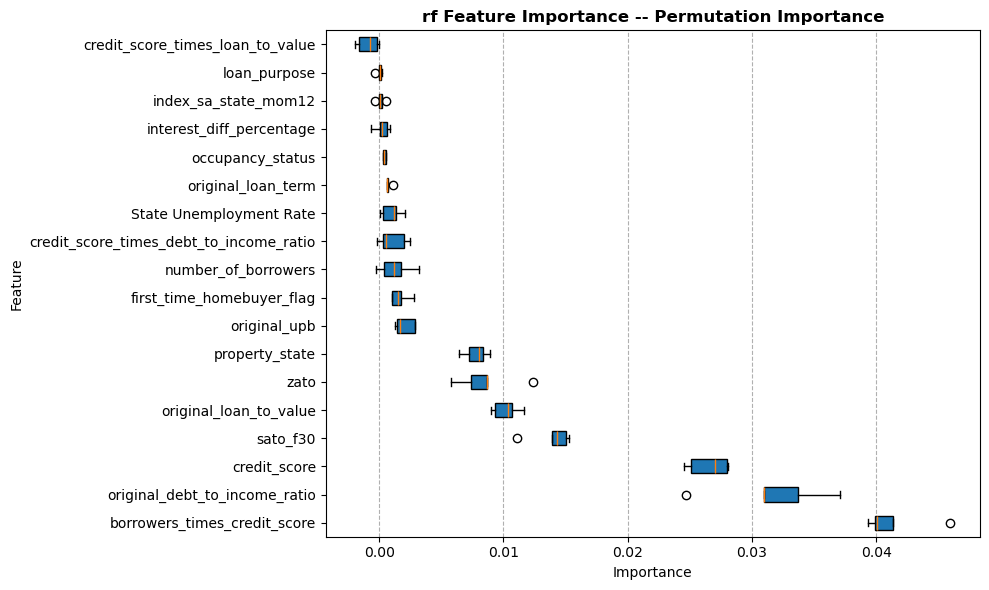

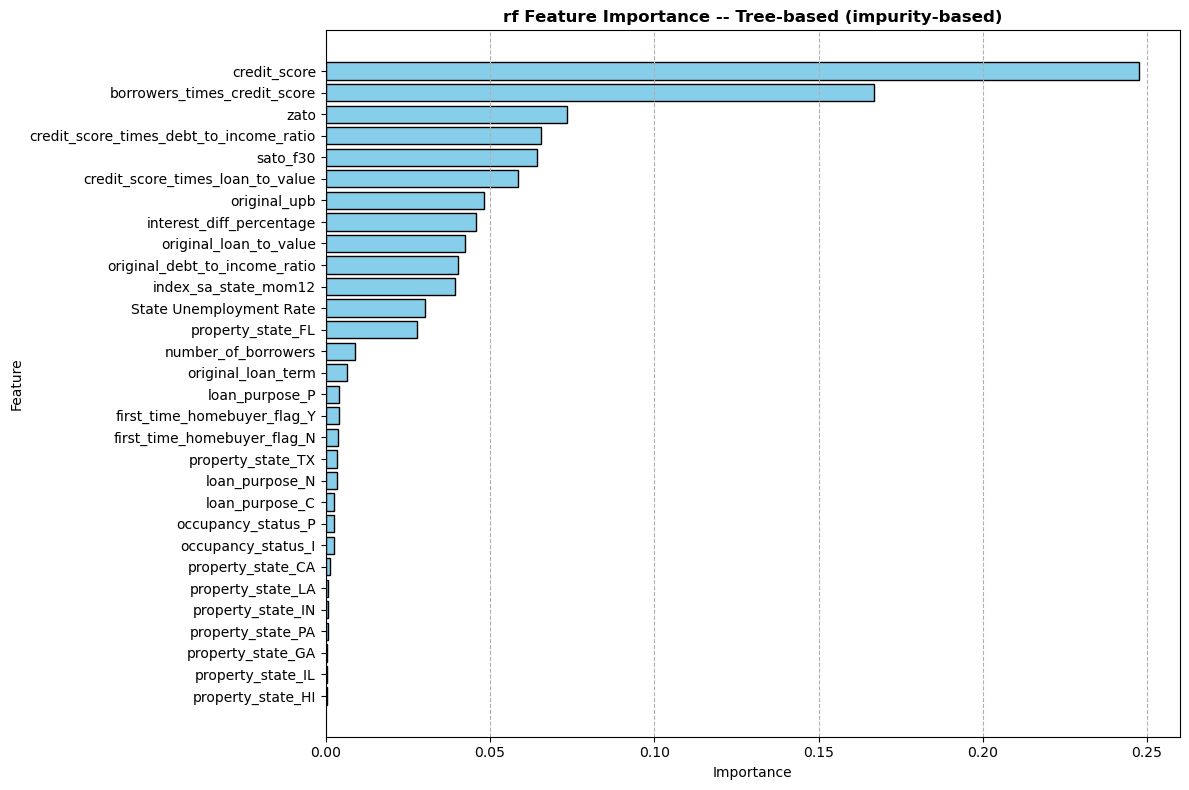

In [28]:
importance_df_rf = hp.compute_group_permutation_importance(
    rf.train(X_train_preprocessed, y_train).model, 
    X_train, 
    X_test, 
    X_val_preprocessed, 
    X_val, 
    y_val, 
    columns=X_val.columns, 
    n=5
)

hp.plot_feature_importance(importance_df_rf, rf)

hp.plot_tree_feature_importance(rf, feature_names)

## XGBoost

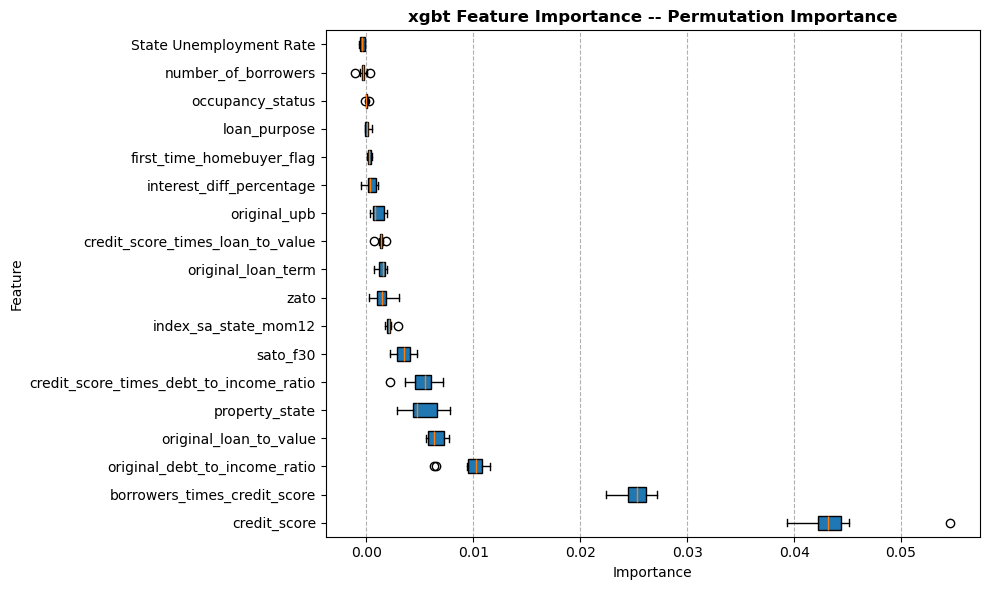

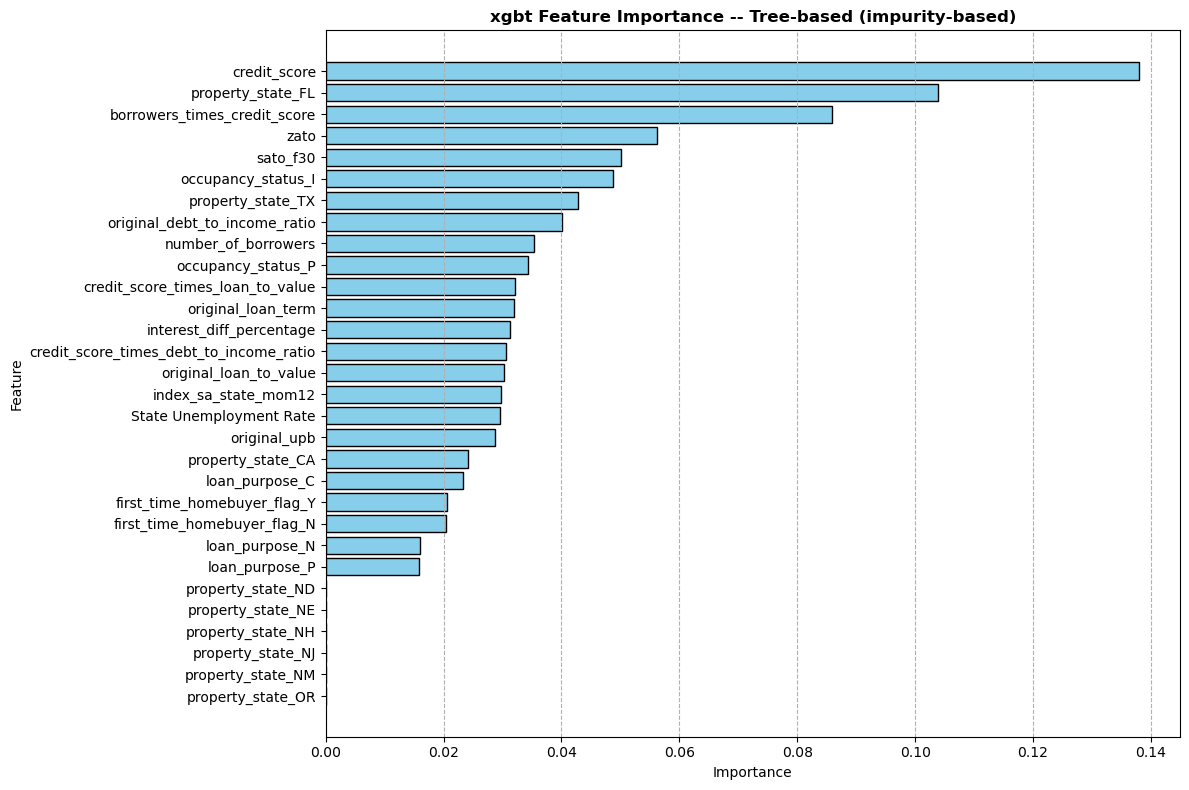

In [29]:
importance_df_xgboost = hp.compute_group_permutation_importance(
    xgboost.train(X_train_preprocessed, y_train).model, 
    X_train, 
    X_test, 
    X_val_preprocessed, 
    X_val, 
    y_val, 
    columns=X_val.columns, 
    n=10
)

hp.plot_feature_importance(importance_df_xgboost, xgboost)


hp.plot_tree_feature_importance(xgboost, feature_names)

## Logistics

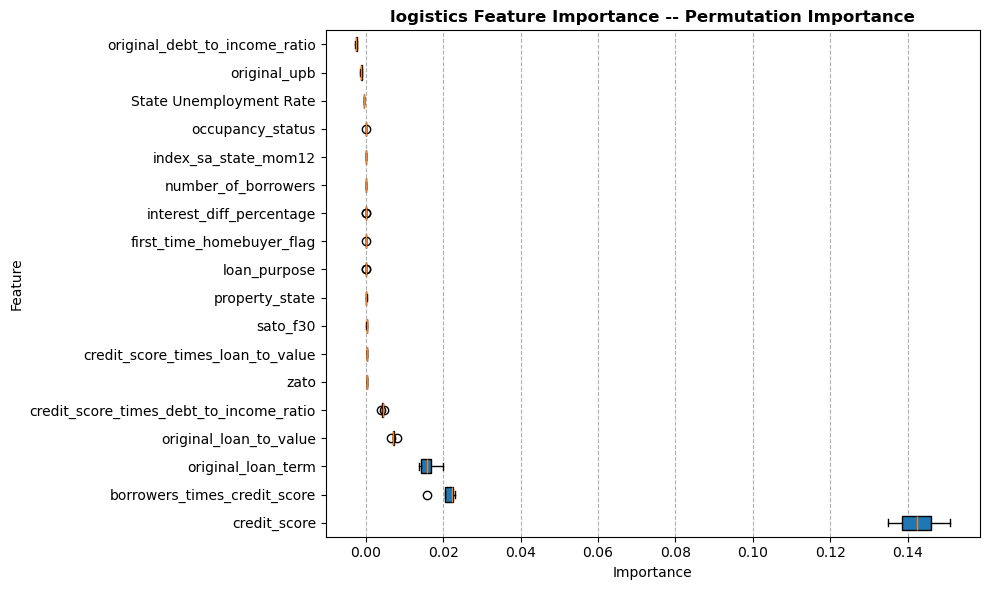

In [30]:
importance_df_logistics  = hp.compute_group_permutation_importance(
    logistics.train(X_train_preprocessed, y_train).model, 
    X_train, 
    X_test, 
    X_val_preprocessed, 
    X_val, 
    y_val, 
    columns=X_val.columns, 
    n=5
)

hp.plot_feature_importance(importance_df_logistics, logistics)

# Overall Comparsion

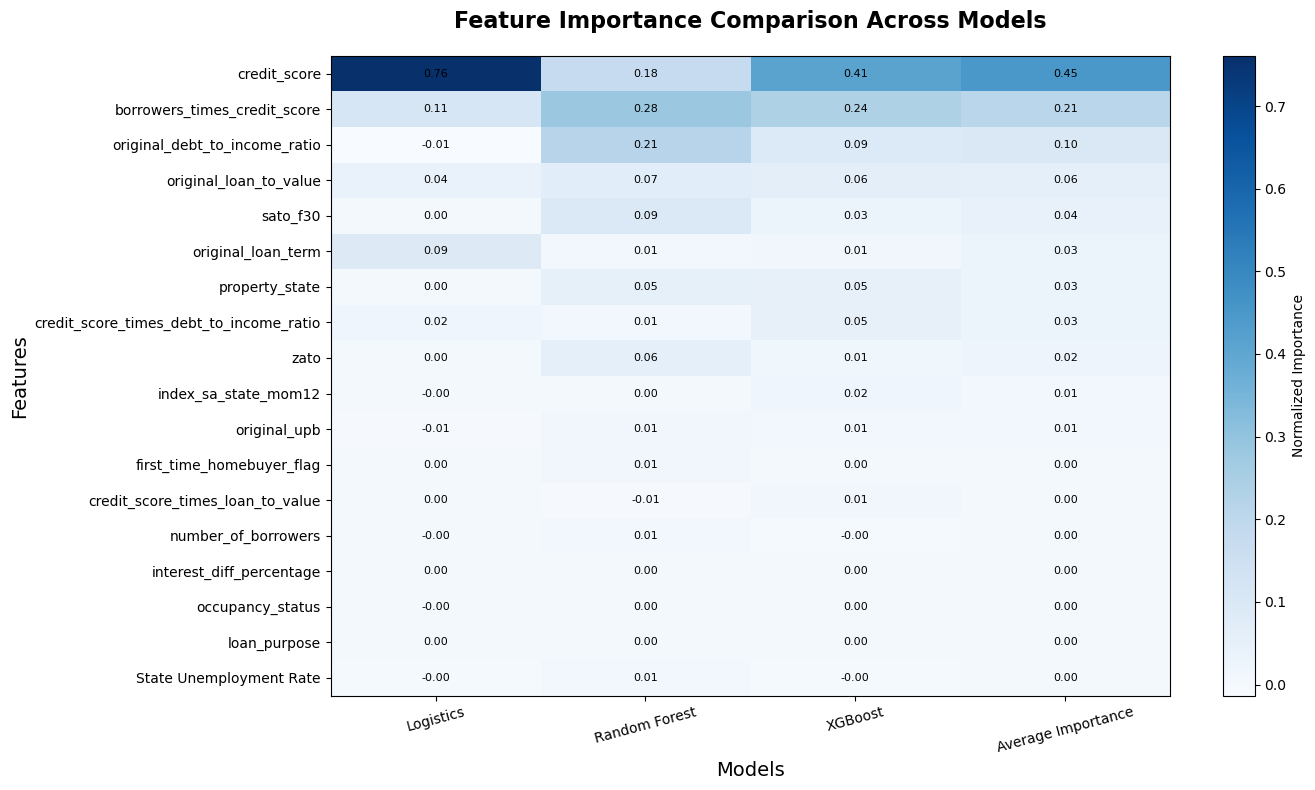

In [31]:
hp.plot_model_feature_importance_comparison(
    model_importance_dfs=[importance_df_logistics, importance_df_rf, importance_df_xgboost],
    model_names=['Logistics', 'Random Forest', 'XGBoost']
)

# Performance
[//]: <> (-.- tabset)

Out of Sample, using validation data from 2020

In [32]:
prob_thresholds = 0.04

## Random Forests

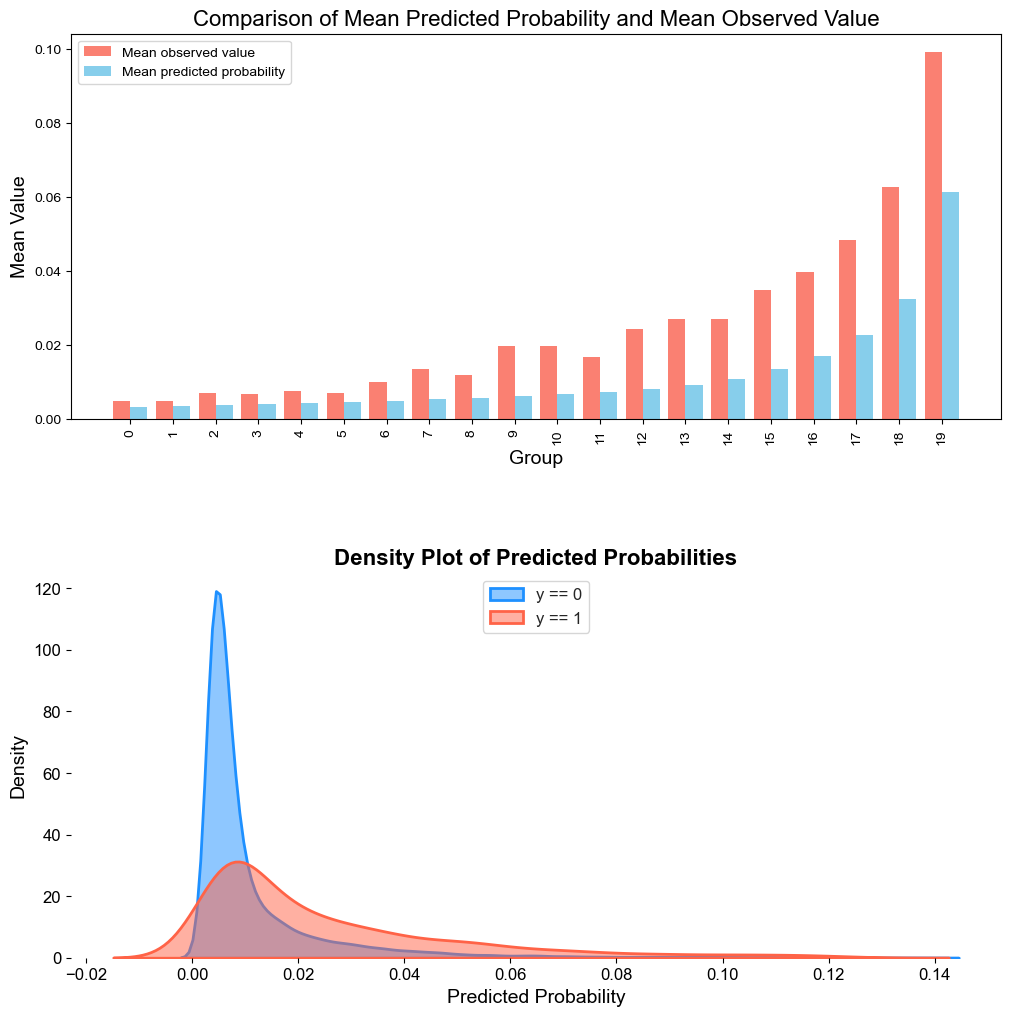

In [33]:
y_pred_prob = rf.model.predict_proba(X_val_preprocessed)[:, 1]
y_pred = np.where(y_pred_prob > prob_thresholds, 1, 0)

hp.plot_density(y_pred_prob, y_pred, y_val)

## XGBoost

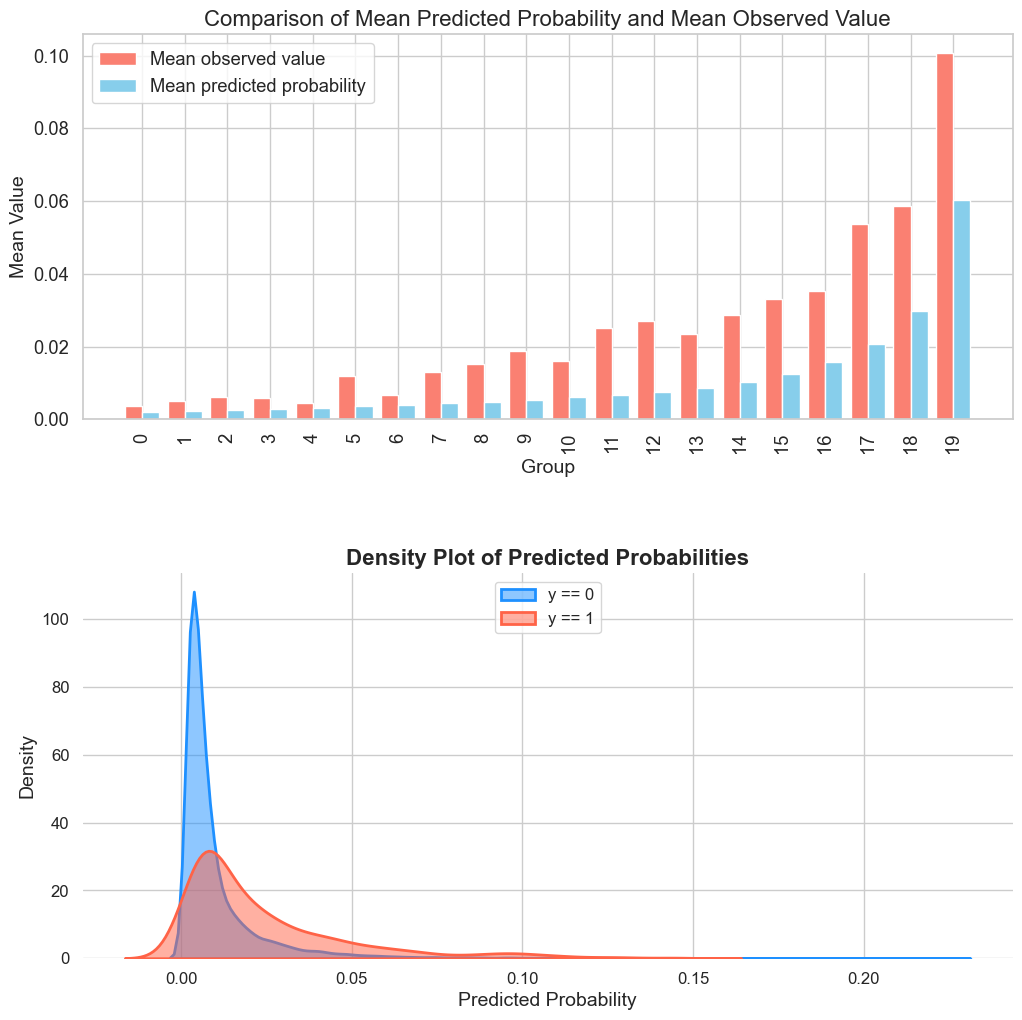

In [34]:
y_pred_prob = xgboost.model.predict_proba(X_val_preprocessed)[:, 1]
y_pred = np.where(y_pred_prob > prob_thresholds, 1, 0)

hp.plot_density(y_pred_prob, y_pred, y_val)

## Logistics

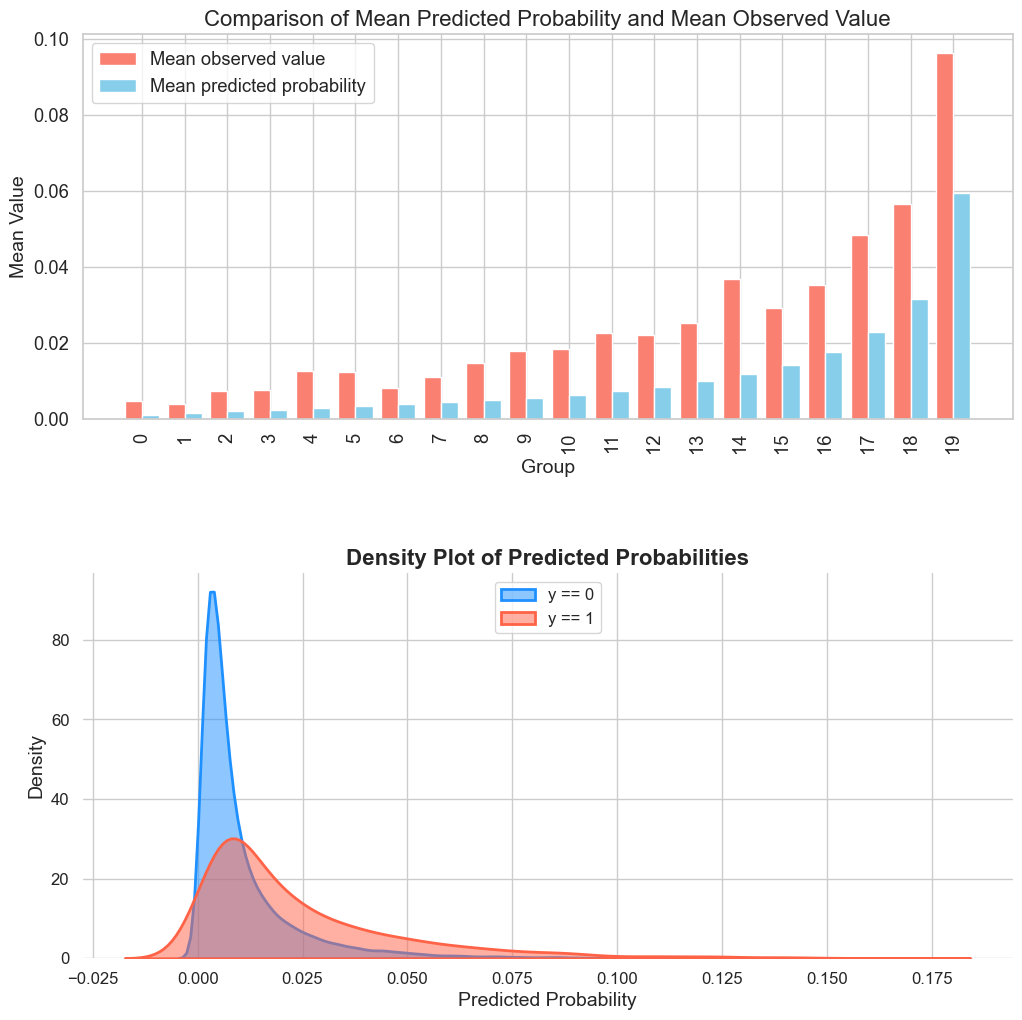

In [35]:
y_pred_prob = logistics.model.predict_proba(X_val_preprocessed)[:, 1]
y_pred = np.where(y_pred_prob > prob_thresholds, 1, 0)

hp.plot_density(y_pred_prob, y_pred, y_val)